In [2]:
import pandas as pd
import json, re
import matplotlib.pyplot as plt
from ibm_watsonx_ai import Credentials, APIClient
from ibm_watsonx_ai.foundation_models import ModelInference
from ibm_watsonx_ai.foundation_models.schema import TextGenParameters
from decouple import Config, RepositoryEnv

In [3]:
# Load the environment variables using python-decouple
# The .env file should be in the root of the project
# The .env file should NOT be committed to the repository

config = Config(RepositoryEnv(".env.paul"))

# Load the credentials
WX_API_KEY = config("WX_API_KEY")

In [4]:
credentials = Credentials(
    url = "https://us-south.ml.cloud.ibm.com",
    api_key = WX_API_KEY
)
client = APIClient(
    credentials=credentials, 
    project_id="68126b74-155e-4a70-aa2c-1781dfad87f6"
)

In [5]:
# --- Setup the Model ---
params = TextGenParameters(
    temperature=0.05,           # Light creativity
    max_new_tokens=300          # Enough for descriptive text
)

model = ModelInference(
    api_client=client,
    params=params,
    model_id="meta-llama/llama-3-3-70b-instruct",
)

In [6]:
def create_prompt(sign_name: str) -> str:
    return (
        f"You are an American Sign Language (ASL) teacher.\n\n"
        f"Please clearly explain how to perform the ASL sign on a beginner level for '{sign_name}'. "
        f"Use simple language and full sentences. Do not assume any prior knowledge about ASL.\n\n"
        f"Here you can find one exampl for the word'all':\n"
        f"'Begin with both hands in front of you. Your non-dominant hand should be closer to you and be oriented towards yourself. Your dominant hand should be oriented away from yourself. Rotate your dominant hand so that its palm is oriented toward yourself and then rest the back of your dominant hand against the palm of your non-dominant hand'"
        f"Only output the explanation. Do not include any other text. If appropriate, use less tokens than available.\n\n"
    )

In [7]:
# --- Generate ASL Description ---
def generate_asl_description(sign_name: str) -> str:
    prompt = create_prompt(sign_name)
    
    response = model.generate(prompt=prompt)
    generated_text = response['results'][0]['generated_text']
    
    return generated_text

Judge

In [8]:
# Separate model instance for evaluation (judge), we are always using llama-3-3-70b-instruct based on literature review
params = TextGenParameters(
    temperature=0.01,
    max_new_tokens=100,
)


judge_model = ModelInference(
    api_client=client,
    params=params, 
    model_id="meta-llama/llama-3-3-70b-instruct",
)

Mass evaluation

In [9]:
def create_comparison_judge_prompt(sign_name: str, generated_description: str, expected_description: str, guardrails="json") -> str:
    return f"""You are evaluating the quality of an ASL sign description based on 3 criteria by comparing it to an expected definition.

Sign: "{sign_name}"

Expected (ground truth) description:
"{expected_description}"

Generated description:
"{generated_description}"

The criteria are:
1. Faithfulness: Can the content of the generated description be inferred from the expected definition?
2. Answer Relevance: Does the answer specifically and sufficiently describe the requested sign?
3. Context Relevance: Does the answer exclusively contain information that is needed to describe the sign?

Use the following scale:
- 1 = fully meets the criterion
- 0.5 = partially meets the criterion
- 0 = does not meet the criterion

Here are a few examples of how to answer:
- example 1:
  - expected description "Mimic the motion of tossing a salad by placing both hands next to each other in front of your with your palms oriented toward each other, and then slightly moving your hands toward each other and up a couple of times."
  - generated description "Move like tossing a salad: hold both hands next to each other in front of you with the palms facing one another, then raise them slightly while bringing them inward toward each other a couple of times."
  - response: "faithfulness": 1, "answer_relevance": 1, "context_relevance": 1
- example 2:
  - expected description "Mimic the motion of tossing a salad by placing both hands next to each other in front of your with your palms oriented toward each other, and then slightly moving your hands toward each other and up a couple of times."
  - generated description "Dance in a circle like you never danced before."
  - response: "faithfulness": 0, "answer_relevance": 0, "context_relevance": 0
- example 3:
  - expected description "Mimic the motion of tossing a salad by placing both hands next to each other in front of your with your palms oriented toward each other, and then slightly moving your hands toward each other and up a couple of times."
  - generated description "To sign 'salad' in American Sign Language (ASL), follow these steps: 1. Start with your dominant hand open and facing up, palm facing you. 2. Bring your hand down to your lap or any stable surface in front of you, keeping your fingers together and your thumb extended out to the side. 3. Touch your index finger and your middle finger together, keeping your other fingers straight. 4. Move your hand back up to your face level, keeping your fingers together and your thumb extended out to the side. 5. This time, bring your hand closer to your chin, as if you're eating a small bite of salad. 6. While moving your hand up, slightly bend your index and middle fingers to mimic the shape of a leaf. 7. Keep your thumb extended out to the side and your other fingers straight. 8. Finally, move your hand down to your lap or any stable surface in front of you, keeping your fingers together and your thumb extended out to the side. Remember, practice makes perfect. Keep practicing the sign for 'salad' until you feel comfortable with it. Good luck!"
  - response: "faithfulness": 0.5, "answer_relevance": 0.5, "context_relevance": 0.5
- example 4:
  - expected description "Begin with the side of your index finger against your forehead and then move your hand up and away from your head."
  - generated description "Hello user, this is a great converstaion starter. I also love to say 'hello' in the beginning of a conversation. To sign 'hello' in American Sign Language (ASL), place the side of your index finger against your forehead and then move your hand up and away from your head. This is a friendly gesture that is commonly used in ASL to greet someone. Remember to smile and make eye contact while signing 'hello' to convey warmth and friendliness."
  - response: "faithfulness": 0.5, "answer_relevance": 1, "context_relevance": 0.5
- example 5:
  - expected description "Begin with the side of your index finger against your forehead and then move your hand up and away from your head."
  - generated description "Start with the edge of your index finger touching your forehead, then lift your hand upward and out, away from your head. And by the way, tomorrow will be a great day for swimming!"
  - response: "faithfulness": 0.5, "answer_relevance": 1, "context_relevance": 0.5
- example 6:
  - expected description "Begin with the side of your index finger against your forehead and then move your hand up and away from your head."
  - generated description "Touch the tip of your middle finger to your chin with the palm facing inward, then flick your hand forward and downward away from your face."
  - response: "faithfulness": 0, "answer_relevance": 0.5, "context_relevance": 0

Think carefully for each criterion before answering.

Respond only in the following format, enclosed within <output> tags:

<output>
{{
  "faithfulness": <0, 0.5, or 1>,
  "answer_relevance": <0, 0.5, or 1>,
  "context_relevance": <0, 0.5, or 1>
}}
</output>
"""


In [10]:
def evaluate_against_ground_truth(sign_name: str, generated_description: str, expected_description: str) -> dict:
    prompt = create_comparison_judge_prompt(sign_name, generated_description, expected_description)

    def try_parse_response(response_text: str) -> dict:
        result = {
            "faithfulness": None,
            "answer_relevance": None,
            "context_relevance": None
        }

        # Try direct parse
        try:
            # Strip leading text if any
            json_start = response_text.find("{")
            if json_start != -1:
                response_text = response_text[json_start:]

            parsed = json.loads(response_text)
            if isinstance(parsed, dict):
                result.update(parsed)
                return result
        except Exception:
            pass

        # Try fallback regex
        matches = re.findall(r"\{.*?\}", response_text, re.DOTALL)
        for match in matches:
            try:
                parsed = json.loads(match)
                if isinstance(parsed, dict):
                    result.update(parsed)
                    return result
            except Exception as e:
                continue

        return result  # fallback with None values if all fails

    # First attempt
    response = judge_model.generate(prompt=prompt)
    judged_text = response['results'][0]['generated_text']
    result = try_parse_response(judged_text)

    # Retry once if parsing failed
    if any(v is None for v in result.values()):
        print(f" First parse failed for sign '{sign_name}', retrying once...")
        response_retry = judge_model.generate(prompt=prompt)
        judged_text_retry = response_retry['results'][0]['generated_text']
        result = try_parse_response(judged_text_retry)

    # Final message if still failing
    if any(v is None for v in result.values()):
        print(f" Failed to parse JSON after retry for sign: '{sign_name}'.")

    return result


In [11]:
#Testing judge with manual input
sign = "hello"
expected = "Begin with the side of your index finger against your forehead and then move your hand up and away from your head."
generated = "Start with the side of your index touching your forehead, then extend your pinky"

scores = evaluate_against_ground_truth(sign, generated, expected)

print("\nJudge Result:")
print(f"Faithfulness: {scores['faithfulness']}")
print(f"Answer Relevance: {scores['answer_relevance']}")
print(f"Context Relevance: {scores['context_relevance']}")



Judge Result:
Faithfulness: 0.5
Answer Relevance: 0.5
Context Relevance: 0


In [12]:
# Define signs and their expected definitions
test_data = [
    {"sign": "car", "expected": "Begin with both hands in front of you with your dominant hand closer to you, your hands pointing up, and your palms oriented to the side in opposite directions. Begin with your hands slightly away from each other and then have them make contact with each other 2 times."},
    {"sign": "city", "expected": "With both hands next to each other in front of you and your palms oriented toward each other, move your hands forward and backwards slightly a couple of times, touching your fingertips together as your hands move past each other."},
    {"sign": "dog", "expected": "Extend the index finger straight up and touch the tip of the thumb to the tip of the middle finger with the ring and pinky fingers bent in the same way as the middle finger. Alternatively, tap your hip and then snap your fingers."},
    {"sign": "door", "expected": "Begin with both hands in front of you and next to each other, with your hands touching on the index finger side of your hands. Rotate the wrist of your dominant hand inward toward yourself a couple of times. This sign mimics a door opening."},
    {"sign": "bone", "expected": "Begin with both hands near your chest with your arms crossed at the wrist and your palms oriented towards yourself. Then, hit your wrists against each other 2 times."},
    {"sign": "food", "expected": "With your palm orientation towards yourself, place your fingertips against your mouth. Tap your fingertips against your mouth 2 times."},
    {"sign": "friend", "expected": "Begin with your index fingers oriented toward each other, with your dominant hand oriented away from yourself and your non-dominant hand oriented toward yourself. Bring your index fingers toward each other until they make contact and then rotate your hands so that your palm orientations are reversed and then make contact with your index fingers again."},
    {"sign": "game", "expected": "Place both hands in front of you with your thumbs pointing up and your palms oriented toward yourself. Tap the back of your curled in fingers against each other a couple of times."},
    {"sign": "house", "expected": "Make the outline of a house with your hands by starting with your index fingers against each other, moving both hands away from each other, and then moving them down."},
    {"sign": "look", "expected": "With your hands oriented toward each other, move them both in a staggered, circular motion that move from above your shoulders to in front of your face a couple of times."},
    {"sign": "frog", "expected": "Place your hand underneath your chin with your palm oriented down. Then, extend your index and middle fingers out 2 times."},
    {"sign": "frequently", "expected": "Begin with your hand near your shoulder. Move your hand away from yourself while also slightly moving it up and down."},
    {"sign": "often", "expected": "Tap the fingertips of your dominant hand on the bottom of the palm of your non-dominant hand, and then tap it again a few times as you move it toward the top of your non-dominant hand."},
    {"sign": "sometimes", "expected": "With your dominant hand horizontally in front of you, place the tip of your index finger above the palm side of your non-dominant hand. Then, move your index finger in a circular motion that first begins by moving down and back. The index finger should make contact with the palm side of your non-dominant hand each time your index finger moves down."},
    {"sign": "observe", "expected": "With both hands next to each other in front of you with your palms oriented down and your index and middle fingers pointing away from each other, move both hands in a circular rotation a couple of times."},
    {"sign": "football", "expected": "Begin with both hands in front of you with your hands oriented toward each other and slightly diagonal. Then, move your hands toward each other until your fingers are interlocked a couple of times."},
    {"sign": "military", "expected": "With your dominant hand above your non-dominant hand and your palms oriented toward yourself, tap both hands on your chest in unison a couple of times."},
    {"sign": "helicopter", "expected": "Place the palm of your dominant hand on top of the index finger of your non-dominant hand. Slightly rotate your wrist back and forth a few times. This sign mimics the movement and shape of a helicopter."},
    {"sign": "airplane", "expected": "Have your palm oriented downwards with your arm in front of you and elevated. Slightly move your hand forward 2 times. This sign mimics an airplane being in the air."},
    {"sign": "ocean", "expected": "Begin with both hands next to each other in front of you with your palms oriented away from yourself. Move your hands away from yourself, while slightly bending your wrists forward and back as your hands move forward."},
    {"sign": "visit", "expected": "Begin with both hands next to each other close to your chest with your palms oriented toward yourself. Then, move both hands in unison forward, away from yourself."},
    {"sign": "travel", "expected": "Begin with your hand in front of you with your palm oriented away from yourself and your hand vertical. Then, move your hand in a circular motion that begins by first moving your hand to the inside and then down. As your hand moves, you should be slightly moving it forward."},
    {"sign": "success", "expected": "Begin with both hands in front of you, diagonally pointing up and to the inside, and with your palms oriented to yourself. The index finger of your dominant hand should be against your chin, and your dominant hand should be further in front of you and in a slightly lower position. Then, rotate your wrists forward until your index fingers are pointing up and your palms are oriented away from yourself."},
    {"sign": "result", "expected": "Begin with both hands in front of you with your non-dominant hand horizontal and oriented toward yourself. The index and middle fingers of your dominant hand should be pointing away from yourself and be above the fingers of your non-dominant hand. Then, move your dominant hand to the side, past the fingers of your non-dominant hand, and then move your dominant hand down."},
    {"sign": "below", "expected": "With your hands in front of you and facing each other, keep your non-dominant hand in place, and move your dominant hand underneath your non-dominant hand."},
    {"sign": "wet", "expected": "Begin with both hands next to each other in front of you with your fingertips pointing up. Then, move your hands down a couple of times, bringing your fingertips together each time."},
    {"sign": "sweat", "expected": "Begin with both palms oriented toward your face with the backs of your fingers against your cheeks on both sides of your face. Then, bend your wrists down while opening up your fingers, mimicking sweat moving down both sides of your face."},
    {"sign": "sandals", "expected": "Slide the curled in index finger of your dominant hand in between the index and middle fingers of your dominant hand from the fingertips to the base of the fingers, mimicking a sandal strap being placed in between toes."},
    {"sign": "winter", "expected": "Begin with your hands in a vertical position next to each other with your palms oriented toward each other. The fingertips of your thumb and pinkie fingers should be close to each other. Then, slightly tap the fingertips of your thumb and index fingers together a couple of times."},
    {"sign": "outside", "expected": "Begin with your dominant hand in a raised position in front of you and to the side with your palm oriented toward yourself. Then, move your hand slightly away from yourself while bringing your fingertips together 2 times."},
    {"sign": "restroom", "expected": "Begin with your hand in front of you with your palm oriented down and your index and middle fingers pointing away from yourself. Bend your wrist down, and then move your hand back up and to the side, then bend your wrist down again."},
    {"sign": "ambulance", "expected": "Begin with both hands in front of you and your forearms vertical. Move your hands in a circular motion a couple of times. As you do each circle, open the fingertips of each hand. As you end each circle, you should close the fingertips back to the original handshape. This sign mimicks the lights of an ambulance flashing."},
    {"sign": "hospital", "expected": "Begin with your index and middle fingers pointing up and your hand near the opposite side of your forehead. Then, bring the thumb side of your hand against that side of your forehead, then bring it across and make contact with the other side of your forehead."},
    {"sign": "gym", "expected": "Tap your thumbs against the sides of your chest near your shoulders a couple of times."},
    {"sign": "heart", "expected": "Tap your middle finger on your chest where your heart is a couple of times."},
    {"sign": "emotions", "expected": "Begin with both hands in front of your chest with your hands oriented toward yourself. Then, alternate moving both hands toward then slightly up your chest a couple of times."},
    {"sign": "toy", "expected": "Begin with both hands next to each other in front of you with your palms oriented toward each other. Then, slightly rotate your wrists from side to side a couple of times."},
    {"sign": "young", "expected": "Begin with your hands next to each other in front of you with your palms oriented toward yourself and your fingers pointing at your chest. Then, move your hand toward yourself and slightly up, touching your fingertips on your chest 2 times."},
    {"sign": "nephew", "expected": "With the thumb side of your hand against the side of your forehead, slightly rotate your wrist back and forth a couple of times."},
    {"sign": "husband", "expected": "Begin with your palms oriented toward each other with the back of your dominant hand against your forehead and your non-dominant hand placed in front of you. Then, bring your dominant hand down until both of your palms are interlocked."},
    {"sign": "themselves", "expected": "Begin with your hand in front of you with your hand pointing away from yourself. Then, move your hand slightly forward and then to the side."},
    {"sign": "together", "expected": "Begin with both hands next to each other in front of you with your palms oriented towards each other and your hands pressed against each other. Then, move both hands in unison in a circular motion."},
    {"sign": "only", "expected": "Begin with your hand in front of you with your index finger pointing up and your palm oriented away from yourself. Then, rotate your wrist to the inside so that your palm is oriented toward yourself."},
    {"sign": "complete", "expected": "Begin with your dominant hand above the fingertips of your non-dominant hand with your dominant hand pointing away from you and your non-dominant hand pointing to the side. Then, move your dominant hand to the edge of your dominant hand and then move your dominant hand down past your fingertips."},
    {"sign": "stuck", "expected": "Begin with your hand in front of your neck with your palm oriented toward yourself and your index and middle fingers pointing at your neck, then move your hand back until your index and middle fingers are touching your neck."},
    {"sign": "money", "expected": "Begin with both hands in front of you with the palm of your non-dominant hand facing up. Bring your dominant hand down to your non-dominant hand a couple of times, with the back of the fingers of your dominant hand touching the palm of your non-dominant hand."},
    {"sign": "compassion", "expected": "Begin with both middle fingers on your chest. Then rotate your hands forwards, point your middle fingers down, and then make a circular motion a couple of times."},
    {"sign": "god", "expected": "Begin with your hand in front of your forehead with the thumb side of your hand closest to your head. Your hand should begin slightly angled forwards. Then you should straighten out your hand until your fingers are facing up, bring your hand a little bit closer to your face, then bring your hand down."},
    {"sign": "pet", "expected": "With both hands in front of you, have the index finger of your dominant hand pointing up and your non-dominant hand behind it. Then, drag the fingers of your dominant hand down your index finger while bending them in a couple of times."},
    {"sign": "lemon", "expected": "With your hand in a vertical position in front of your face, rotate your wrist a couple of times so that your thumb passes your chin each time."},
    {"sign": "wine", "expected": "Begin with your hand next to your mouth with your fingers pointing at your face. Then, move your hand in a circular motion a couple of times that first begins by moving forward and down."},
    {"sign": "tournament", "expected": "Begin with both hands next to each other in front of you with your hands vertical and your palms oriented away from yourself. Then, move your hands up and down in opposite directions a couple of times."},
    {"sign": "camera", "expected": "Begin with both hands on the side of your face with your palms oriented toward each other. Then, curl the index finger of your dominant hand a couple of times. This sign mimics a person holding a camera and taking a picture."},
    {"sign": "screen", "expected": "Begin with both hands in front of your face, with your index fingers touching each other. Then, bring your index fingers, out, down, and then in, making the outline of a rectangular screen with your fingers."},
    {"sign": "interact", "expected": "Begin with both hands in front of you with your dominant hand in front of your non-dominant hand. Then, move your hands away and toward yourself in opposite directions a couple of times."},
    {"sign": "behave", "expected": "Begin with both hands in front of you with your palms oriented downward and your fingertips pointing away from yourself. Move your hands from side to side in unison a couple of times."},
    {"sign": "argue", "expected": "Begin the sign with both hands in front of you and your index fingers pointed at each other. Then, rotate your hands forward a couple of times."},
    {"sign": "hear", "expected": "Begin with your hand next to the side of your head with your thumb pointing toward your ear. Then, move your thumb toward your ear while curling your index and middle fingers in."},
    {"sign": "preach", "expected": "Begin with your hand vertically oriented away from yourself in front of you and move your hand slightly forward a couple of times."},
    {"sign": "talented", "expected": "Begin with your dominant hand vertically in front of you with your palm oriented to the side. Wrap the fingers of your dominant hand around the pinkie side of your palm. Then, move your dominant hand forward while moving your fingertips to your palm."},
    {"sign": "shy", "expected": "Begin with the backs of your fingers against your cheek with your palm oriented forward. Then, rotate your wrist in, keeping your fingers against your cheek, until your palm is oriented toward yourself."},
    {"sign": "flirt", "expected": "Place both hands in front of you with your thumbs touching each other and the palm of your hands oriented down. Then move both your hands forwards together while wiggle all of your fingers except for your thumbs."},
    {"sign": "handsome", "expected": "With your palm oriented toward your face, move your hand in a circle around your face one time."},
    {"sign": "delicious", "expected": "Begin with your hand in front of your mouth with your palm oriented toward yourself, and then move your hand away from yourself. At the beginning of the sign, your index finger should be next to the tip of your thumb. As your hand move, you should slide your middle finger down to the bottom of your thumb."},
    {"sign": "later", "expected": "Begin with both hands in front of you with the thumb of your hand against the palm of your non-dominant hand. The movement of this sign is done by bending your index finger forward a couple of times."},
    {"sign": "quick", "expected": "Begin with both hands next to each other in front of you with your palms oriented toward each other, then move your hands forward and down. At the beginning of this movement the fingertips of your thumbs should be underneath the fingertips of your index fingers, then at the end your index fingers should be curled in and your thumbs should be pointing up."},
    {"sign": "hurry", "expected": "Begin with your hands next to each other with your index and middle fingers pointing away from you and your wrists slightly tilted up. Then, stagger moving both of your hands in a circular motion a couple of times."},
    {"sign": "ahead", "expected": "Begin with both hands in front of you with your dominant hand behind your non-dominant hand. Then, bring your dominant hand around and then in front of your non-dominant hand. This sign mimics one thing/person moving in front of another."},
    {"sign": "tomorrow", "expected": "Begin with your thumb touching the side of your chin with your palm oriented forward. Then, rotate your wrist forward until your thumb is pointing up."},
    {"sign": "nap", "expected": "Begin with your hand in front of your face with the fingertips of your hand pointing at the top of your head. Then, move your hand down to your chin while bringing your fingertips together."},
    {"sign": "clean", "expected": "With both hands oriented towards each other, slide your dominant hand across the palm of your non-dominant hand a couple of times."},
    {"sign": "towel", "expected": "Place your hands to the sides of your neck with your palms oriented away from yourself. Then, move your hands in unison from side to side a couple of times, mimicking a person using a towel to dry off their neck."},
    {"sign": "socks", "expected": "With your index fingers pointing forward and the sides of your index fingers against each other, slightly move your hands away from and toward yourself in alternating directions."},
    {"sign": "join", "expected": "Begin with your dominant hand behind your non-dominant hand. The index and middle fingers of your dominant hand should be pointing up and your non-dominant hand should be oriented so that the opening between your thumb and other fingers is facing your dominant hand. Then, bend the wrist of your right hand down and place your index and middle fingers into the opening between your thumb and other fingers."},
    {"sign": "quit", "expected": "Begin with the index and middle fingers of your dominant hand inside the curled-in fingers of your non-dominant hand. Then, you should move your dominant hand away, moving your index and middle fingers out and then pointing them up."}
]


In [13]:
# Store all scores
all_scores = []

# counter to indictae progress of the evaluation
i=0

for entry in test_data:
    i=i+1
    print(f"\n{i}. Evaluating sign: {entry['sign']}")
    sign = entry["sign"]
    expected = entry["expected"]

    # Generate from LLM
    generated = generate_asl_description(sign)

    # Judge against expected
    scores = evaluate_against_ground_truth(sign, generated, expected)

    all_scores.append(scores)

# Compute and print average for each metric
print("\nAverage Scores:")
faithfulness_avg = sum(s["faithfulness"] for s in all_scores if s["faithfulness"] is not None) / len(all_scores)
print(f"Faithfulness: {faithfulness_avg:.2f}")
relevance_avg = sum(s["answer_relevance"] for s in all_scores if s["answer_relevance"] is not None) / len(all_scores)
print(f"Answer Relevance: {relevance_avg:.2f}")
context_avg = sum(s["context_relevance"] for s in all_scores if s["context_relevance"] is not None) / len(all_scores)
print(f"Context Relevance: {context_avg:.2f}")


1. Evaluating sign: car

2. Evaluating sign: city

3. Evaluating sign: dog

4. Evaluating sign: door

5. Evaluating sign: bone

6. Evaluating sign: food

7. Evaluating sign: friend

8. Evaluating sign: game

9. Evaluating sign: house

10. Evaluating sign: look

11. Evaluating sign: frog

12. Evaluating sign: frequently

13. Evaluating sign: often

14. Evaluating sign: sometimes

15. Evaluating sign: observe

16. Evaluating sign: football

17. Evaluating sign: military

18. Evaluating sign: helicopter

19. Evaluating sign: airplane

20. Evaluating sign: ocean

21. Evaluating sign: visit

22. Evaluating sign: travel

23. Evaluating sign: success

24. Evaluating sign: result

25. Evaluating sign: below

26. Evaluating sign: wet

27. Evaluating sign: sweat

28. Evaluating sign: sandals

29. Evaluating sign: winter

30. Evaluating sign: outside

31. Evaluating sign: restroom

32. Evaluating sign: ambulance

33. Evaluating sign: hospital

34. Evaluating sign: gym

35. Evaluating sign: heart

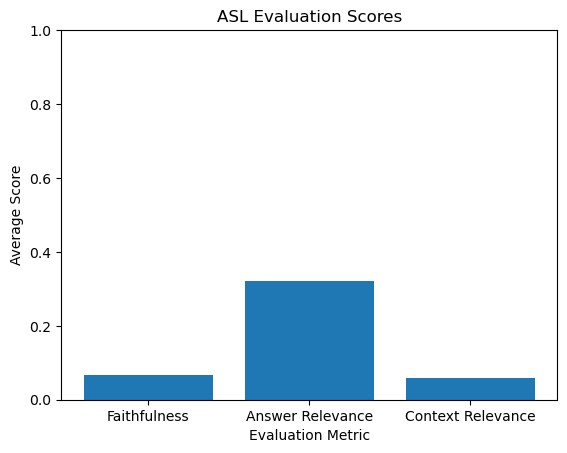

In [14]:
# Plot
labels = ["Faithfulness", "Answer Relevance", "Context Relevance"]
values = [faithfulness_avg, relevance_avg, context_avg]

_, ax = plt.subplots()
ax.bar(labels, values)
ax.set_ylim(0, 1)
ax.set_ylabel("Average Score")
ax.set_xlabel("Evaluation Metric")
ax.set_title("ASL Evaluation Scores")
plt.show()